In [1]:
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
## WRITE OR READ FROM S3 ####
import boto3
import io

s3 = boto3.resource('s3')
output_bucket = "hbo-outbound-datascience-content-dev"
input_bucket = "hbo-ingest-datascience-content-dev"
bucket = s3.Bucket(input_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
def write_to_input(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=input_bucket, Key=filename, Body=content)
    
def read_from_s3(filename, input_bucket = input_bucket):
    for obj in bucket.objects.filter(Prefix='title_hours_viewed_retention/'+filename): #churn_metric_0811
            key = obj.key 
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            df = pd.read_csv(body, na_values = [r'\\\\N'])
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [4]:
data = read_from_s3('Cannibalization Analysis.csv')
data_ca_title = read_from_s3('cannibalization_analysis_detailed_view.csv')

Reading title_hours_viewed_retention/Cannibalization Analysis.csv.csv features
Reading title_hours_viewed_retention/cannibalization_analysis_detailed_view.csv.csv features


# CORRELATION

In [5]:
data.medal.unique()

array(['Bronze', 'Gold', 'Silver', 'Platinum'], dtype=object)

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [7]:
data.head()

,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost,pay_1_count,popcorn_count,movie_count,series_count,acquired_count,original_count,medal_Platinum_count,medal_same_count,genre_same_count,current_content_count
0,Hitman,GV-BGQgMBlMLDwwEAAAAy,0,60,"147,364.96",0.01,2021-10-01,1.54,movies,acquired,2007-11-21,Bronze,nan,Action/Adventure,0,0,"24,000,000.00",0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,0,13.86,"95,399.02",0.01,"285,000.00",6,2,273,82,341,23,1,358,45,46
1,Meet Dave,GV-BH1AH5lhgVsQEAAABJ,0,60,"114,823.42",0.01,2022-09-01,1.51,movies,acquired,2008-07-11,Bronze,nan,Comedy,0,0,"60,000,000.00",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,nan,0,14.14,"76,266.51",0.01,"230,000.00",4,0,171,75,242,6,1,245,46,42
2,The Sand Pebbles,GV-BK7wNv6MLCwgEAAABw,0,60,"6,272.51",0.00,2021-03-01,2.98,movies,acquired,1966-01-01,Bronze,nan,Classics,0,0,"12,000,000.00",0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,nan,0,55.16,"2,102.13",0.00,"230,000.00",1,1,221,29,237,16,2,249,11,32
3,Matchstick Men,GV-BKigrJWcJMwwEAAABi,0,60,"177,819.93",0.01,2021-06-01,1.89,movies,acquired,2003-09-12,Bronze,nan,Drama,0,0,"62,000,000.00",0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,nan,0,17.72,"93,850.14",0.01,"175,000.00",5,2,196,51,234,13,2,243,55,20
4,Miracle on 34th Street,GV-BKvAt0FsJMwwEAAABv,0,60,"2,531.15",0.00,2021-07-01,1.61,movies,acquired,1947-01-01,Bronze,nan,Kids/Family,0,0,nan,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,nan,0,74.50,"1,575.68",0.00,"92,000.00",7,1,172,21,179,16,0,185,18,39


In [8]:
META_COLS = ['title_name', 'title_id', 'season_number', 'offering_start_date', 'asset_run_time_hours']
FEATURE_COLS = [
                'pay_1_count', 'popcorn_count', 'movie_count', 'series_count', 'acquired_count', 'original_count', 
                'medal_Platinum_count', 'medal_same_count', 'genre_same_count', 'current_content_count', 'medal_number'
               ]

In [9]:
TARGET_COL = ['ahvr'] #cumulative_hours_viewed

In [10]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,ahvr
dummy_value,-1.00
medal_number,-0.72
medal_same_count,-0.29
movie_count,-0.11
acquired_count,-0.10
genre_same_count,-0.07
series_count,-0.05
current_content_count,-0.05
original_count,-0.03
pay_1_count,-0.02


<AxesSubplot:>

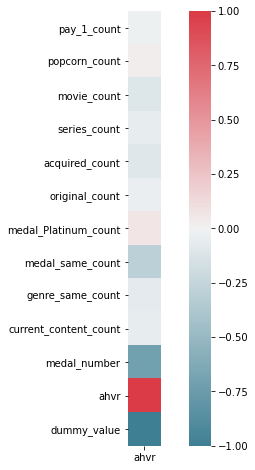

In [11]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)

## 1. Which medal are mostly impacted by the title of same medal?

In [11]:
data[data['medal'].isin(['Platinum', 'Gold'])].medal_same_count.max()

5

In [12]:
data.groupby(['medal']).count()['title_name']

medal
Bronze      3564
Gold          45
Platinum      25
Silver        60
Name: title_name, dtype: int64

In [13]:
data.medal.unique()

array(['Bronze', 'Gold', 'Silver', 'Platinum'], dtype=object)

### Platinum

In [15]:
plot_data=data[data['medal'].isin(['Platinum'])][FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,ahvr
dummy_value,-1.00
series_count,-0.30
pay_1_count,-0.27
current_content_count,-0.24
original_count,-0.15
acquired_count,-0.01
genre_same_count,0.03
movie_count,0.10
medal_Platinum_count,0.13
medal_same_count,0.13


### Gold

In [16]:
plot_data=data[data['medal'].isin(['Gold'])][FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,ahvr
dummy_value,-1.00
popcorn_count,-0.18
medal_Platinum_count,-0.13
genre_same_count,-0.09
original_count,-0.09
series_count,0.05
pay_1_count,0.08
current_content_count,0.12
medal_same_count,0.16
movie_count,0.17


In [25]:
plot_data=data[data['medal'].isin(['Gold', 'Platinum'])]
corr = plot_data[FEATURE_COLS+TARGET_COL].corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,ahvr
dummy_value,-1.00
current_content_count,-0.29
original_count,-0.28
medal_same_count,-0.20
series_count,-0.19
pay_1_count,-0.09
genre_same_count,-0.02
acquired_count,0.10
movie_count,0.16
popcorn_count,0.23


In [28]:
data_ca_title[(data_ca_title['title_id'] == 'GYJxCDACcN8PDewEAAAAG') 
              &(data_ca_title['medal_2'] == 'Platinum')]

,title_id,title_name,season_number,offering_start_date,medal,pillar_genre,date_start,date_end,title_id_2,title_name_2,season_number_2,offering_start_date_2,content_category_2,program_type_2,air_date_2,medal_2,pillar_genre_2,is_pay_1_2,is_popcorn_2,is_movie_2,is_series_2,is_acquired_2,is_original_2,is_medal_Platinum,is_medal_same,is_genre_same,is_current
381230,GYJxCDACcN8PDewEAAAAG,Friends: The Reunion,0,2021-05-27,Platinum,Other,2021-04-26 00:00:00,2021-06-27 00:00:00,GYJxCDACcN8PDewEAAAAG,Friends: The Reunion,0,2021-05-27,special,original,2021-05-27,Platinum,Other,0,0,0,0,0,1,1,1,1,1
381231,GYJxCDACcN8PDewEAAAAG,Friends: The Reunion,0,2021-05-27,Platinum,Other,2021-04-26 00:00:00,2021-06-27 00:00:00,GYK0x7gXCza4OwwEAAADl,In The Heights,0,2021-06-10,movies,acquired,2021-06-10,Platinum,Drama,1,1,1,0,1,0,1,1,0,1
381312,GYJxCDACcN8PDewEAAAAG,Friends: The Reunion,0,2021-05-27,Platinum,Other,2021-04-26 00:00:00,2021-06-27 00:00:00,GYLEE7gB0zcLCwgEAAAHj,The Conjuring: The Devil Made Me Do It,0,2021-06-04,movies,acquired,2021-06-04,Platinum,Horror,1,1,1,0,1,0,1,1,0,1


In [29]:
# plot_data.sort_values(by = ['medal_Platinum_count','ahvr'], ascending = False)

### Silver

In [17]:
plot_data=data[data['medal'].isin(['Silver'])][FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,ahvr
dummy_value,-1.00
original_count,-0.05
medal_same_count,0.04
movie_count,0.05
series_count,0.06
current_content_count,0.07
acquired_count,0.08
genre_same_count,0.10
medal_Platinum_count,0.17
pay_1_count,0.19


### Bronze

In [18]:
plot_data=data[data['medal'].isin(['Bronze'])][FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,ahvr
dummy_value,-1.00
current_content_count,-0.05
original_count,-0.04
medal_same_count,-0.04
acquired_count,-0.04
genre_same_count,-0.04
movie_count,-0.04
series_count,-0.04
pay_1_count,-0.01
popcorn_count,0.01


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


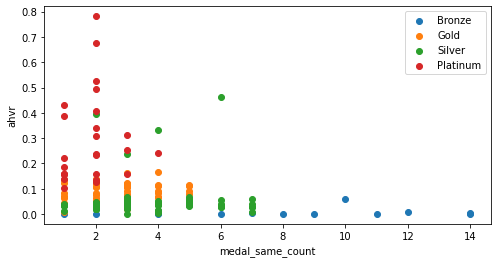

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))

for i in data.medal.unique():
    plot_df = data[data['medal'] == i][data['medal_same_count'] <=20]
    plot_df.sort_values(by = ['medal_same_count'], inplace = True)
    ax.scatter(plot_df['medal_same_count'], plot_df['ahvr'], label=i)

ax.set_xlabel('medal_same_count')
ax.set_ylabel('ahvr')
ax.legend()

plt.show()